### 0. Utilities

#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from utils.constants import EXPORTS_PATH, DIFF_THRESHOLD
from utils.types import IndustryStandard
from utils.maestri import MAESTRI_ROLES, NON_NACE_STDS, read_maestri, get_maestri_code_col
from utils.similarity import get_similarity, get_similarity_col

### 1. Reading the MAESTRI dataset

#### Importing the spreadsheet

In [3]:
# Read the MAESTRI dataset as a DataFrame
maestri_dfs = read_maestri()

In [4]:
maestri_dfs[0].head()

,Company description,NACE code,ISIC code,WZ code,SSIC code
0,Refinery,1920,1920,19200,19201
1,Refinery,1920,1920,19200,19201
2,Steelworks,2410,2410,24520,24310
3,Steelworks,2410,2410,24520,24310
4,Cement production,2351,2394,23510;23650;23610,23940


### 2. Obtaining similarity scores for validation

In [5]:
# Loop through all company types
for i in range(len(MAESTRI_ROLES)):
    # Role: either 'Donor', 'Intermediary' or 'Receiver'
    role = MAESTRI_ROLES[i]
    
    # NACE column, example: 'Provider NACE code'
    nace_col = get_maestri_code_col(IndustryStandard.NACE)
    
    # Iterate through all standards except NACE as it is to be compared with
    for std in NON_NACE_STDS:
        df = maestri_dfs[i]
        
        # Standard column, example for ISIC: 'Donor ISIC code'
        std_col = get_maestri_code_col(std)

        similarity_col = get_similarity_col(std)
        
        # Zip the NACE and standard columns to iterate through
        tuples = zip(df[nace_col], df[std_col])
        
        # Append the similarity score column of a certain standard to the DataFrame for a given role
        df[similarity_col] = [get_similarity(a[0], IndustryStandard.NACE, a[1], std) for a in tuples]
        
        # Convert the similarity score column data type to 'float'
        df[similarity_col] = df[similarity_col].astype(float)
    
    # List containing new order of columns for readability
    cols = [nace_col] + [f(std) for std in NON_NACE_STDS for f in (get_maestri_code_col, get_similarity_col)]
    
    # Reorder columns for readability
    maestri_dfs[i] = maestri_dfs[i][cols]

In [6]:
maestri_dfs[0].head()

,NACE code,ISIC code,ISIC code sim. score,WZ code,WZ code sim. score,SSIC code,SSIC code sim. score
0,1920,1920,1.0,19200,1.0,19201,1.0
1,1920,1920,1.0,19200,1.0,19201,1.0
2,2410,2410,1.0,24520,1.0,24310,1.0
3,2410,2410,1.0,24520,1.0,24310,1.0
4,2351,2394,1.0,23510;23650;23610,1.0,23940,1.0


In [7]:
role_index = 0
role = MAESTRI_ROLES[role_index]

df = maestri_dfs[role_index]
cols = [get_maestri_code_col(IndustryStandard.NACE), get_maestri_code_col(IndustryStandard.WZ)]

df[cols]

,NACE code,WZ code
0,1920,19200
1,1920,19200
2,2410,24520
3,2410,24520
4,2351,23510;23650;23610
...,...,...
300,1081,10810;01140
301,1081,10810;01140
302,1081,10810;01140
303,261,2051;2052;2053;2059


### 3. Model performance statistics

In [8]:
# Score ategories
score_categories = ["s = -1", "s = 0", "0 < s < 1", "s = 1"]

# Determine counts for a given series
get_counts = lambda f: lambda x: {
    "s = -1": [len(arr[(arr == -1)]) for arr in f(x)],
    "s = 0": [len(arr[(arr == 0)]) for arr in f(x)],
    "0 < s < 1": [len(arr[(arr > 0) & (arr < 1)]) for arr in f(x)],
    "s = 1": [len(arr[arr == 1]) for arr in f(x)]
}

# Determine percents for a given series
get_percents = lambda f: lambda x: {
    "s = -1": [len(arr[arr == -1]) / len(arr) for arr in f(x)],
    "s = 0": [len(arr[arr == 0]) / len(arr) for arr in f(x)],
    "0 < s < 1": [len(arr[(arr > 0) & (arr < 1)]) / len(arr) for arr in f(x)],
    "s = 1": [len(arr[arr == 1]) / len(arr) for arr in f(x)]
}

#### By company role and industry classification standard

In [9]:
# Function to extract all scores by role
scores_by_role = lambda std: [np.array(df[get_similarity_col(std)]) for df in maestri_dfs]

# Function to calculate score count breakdown (by role)
scores_counts_by_role = get_counts(scores_by_role)

# Function to calculate score percentage (by role) breakdown
scores_percents_by_role = get_percents(scores_by_role)

#### By industry classification standard

In [10]:
# Function to extract the scores of a given standard
scores_std = lambda std: np.concatenate(scores_by_role(std))

# Function to extract the scores of a set of standards
scores = lambda stds: [scores_std(std) for std in stds]

# Score count breakdown
score_counts_dict = get_counts(scores)(NON_NACE_STDS)

# Score percentage breakdown
score_percents_dict = get_percents(scores)(NON_NACE_STDS)

In [11]:
score_counts_dict

{'s = -1': [0, 0, 0],
 's = 0': [0, 165, 205],
 '0 < s < 1': [0, 32, 22],
 's = 1': [668, 471, 441]}

#### Text representation

In [33]:
similarity_matrix = pd.DataFrame.from_dict(score_percents_dict, orient="index", columns=[std.value for std in NON_NACE_STDS])
similarity_matrix = similarity_matrix.T

In [34]:
similarity_matrix * 100

,s = -1,s = 0,0 < s < 1,s = 1
ISIC,0.0,0.000000,0.000000,100.000000
WZ,0.0,24.700599,4.790419,70.508982
SSIC,0.0,30.688623,3.293413,66.017964


#### Visualising similarity scores

In [13]:
# Bar width for every plot
bar_width = 0.3

# List of named colours for matplotlib
# Source: https://matplotlib.org/stable/gallery/color/named_colors.html
bar_colors = {
    "s = -1": "lightgrey",
    "s = 0": "indianred",
    "0 < s < 1": "orange",
    "s = 1": "mediumseagreen"
}

##### By company role and industry classification standard

In [14]:
# Create a subplot based on a given ICS
def score_subplot(std, ax, is_percent=False):
    # Obtain the dictionary with the breakdown of values by similarity score
    values_dict = scores_percents_by_role(std) if is_percent else scores_counts_by_role(std)
    
    # Initial bar heights
    bottom = np.zeros(len(NON_NACE_STDS))
    
    # Looping through each category ('s = 0', '0 < s < 1', 's = 1')
    for category, values in values_dict.items():
        # Add bars for each category for all roles ('Donor', 'Intermediary', 'Receiver')
        ax.bar(MAESTRI_ROLES, values, bar_width, color=bar_colors[category], label=category, bottom=bottom)
        
        # Increment the base bar heights
        bottom += values
    
    # Set the title of the subplot
    ax.set_title(std.value)
    
    # Rotate the x-ticks by 45 degrees
    ax.tick_params(axis="x", labelrotation=45)
    
    # If the type of plot is a percentage plot,
    if is_percent:
        # format the y-axis to be percentage values
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

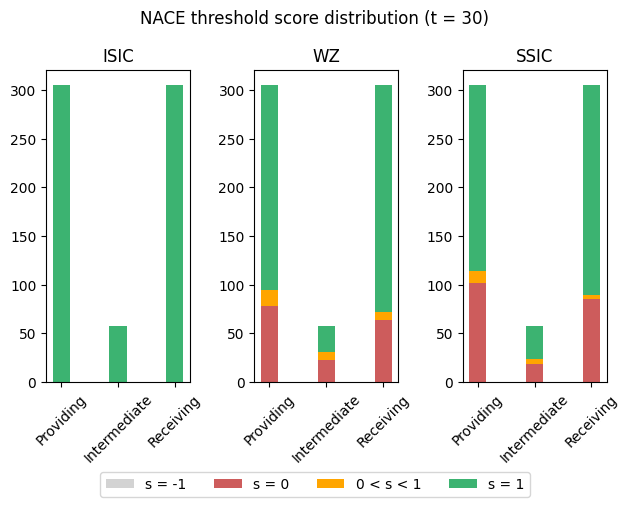

In [15]:
fig, axs = plt.subplots(ncols=len(NON_NACE_STDS))

# Add subplots for each standard
for std, ax in zip(NON_NACE_STDS, axs):
    score_subplot(std, ax)

# Add a legend to the figure
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, ncol=len(score_categories), loc="lower center", bbox_to_anchor=[0.5, -0.05])

# Set the title of the figure
fig.suptitle(f"NACE threshold score distribution (t = {DIFF_THRESHOLD})")

# Add enough padding between subplots to prevent overlapping
fig.tight_layout()

plt.show()

##### By industry classification standard

In [16]:
# Function to extract the scores of a given standard
scores_std = lambda std: np.concatenate(scores_by_role(std))

# Function to extract the scores of a set of standards
scores = lambda stds: [scores_std(std) for std in stds]

# Score count breakdown
score_counts_dict = get_counts(scores)(NON_NACE_STDS)

# Score percentage breakdown
score_percents_dict = get_percents(scores)(NON_NACE_STDS)

In [17]:
# Create a subplot based on a given ICS
def score_plot(ax, is_percent=False):
    # x-axis values
    x = [std.value for std in NON_NACE_STDS]
    
    # Obtain the dictionary with the breakdown of values by similarity score
    values_dict = score_percents_dict if is_percent else score_counts_dict
    
    # Initial bar heights
    bottom = np.zeros(len(x))
    
    # Looping through each category ('s = 0', '0 < s < 1', 's = 1')
    for category, values in values_dict.items():
        # Add bars for each category for all standards ('ISIC', 'WZ', 'SSIC')
        ax.bar(x, values, bar_width, color=bar_colors[category], label=category, bottom=bottom)
        
        # Increment the base bar heights
        bottom += values
    
    # If the type of plot is a percentage plot,
    if is_percent:
        # format the y-axis to be percentage values
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

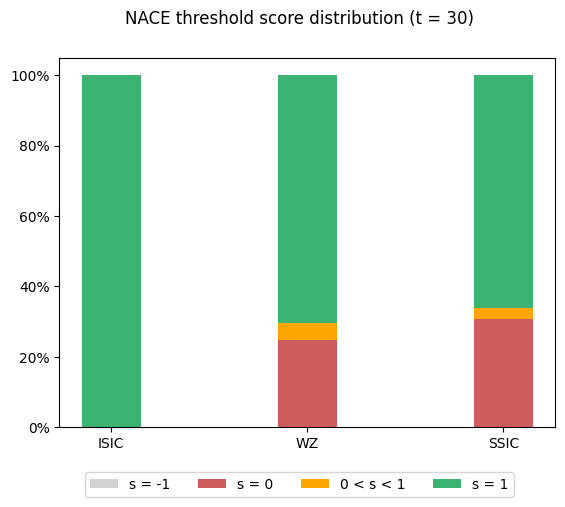

In [18]:
fig, ax = plt.subplots()

# Add bars to the figure
score_plot(ax, is_percent=True)

# Add a legend to the figure
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, ncol=len(score_categories), loc="lower center", bbox_to_anchor=[0.5, -0.05])

# Set the title of the figure
fig.suptitle(f"NACE threshold score distribution (t = {DIFF_THRESHOLD})")

plt.show()

### 4. Exporting results to Excel

In [19]:
with pd.ExcelWriter(f"{EXPORTS_PATH}/Exchanges-database Maestri_accuracy.xlsx") as writer:
    for i in range(len(maestri_dfs)):
        role = MAESTRI_ROLES[i]
        df = maestri_dfs[i]
        
        df.to_excel(writer, sheet_name=role, index=False)
        worksheet = writer.sheets[role]
        workbook = writer.book
        
        format = workbook.add_format()
        format.set_align('left')
        format.set_align('vcenter')
        
        # Loop through all columns
        for index, col in enumerate(df):
            series = df[col]
            max_len = max((
                series.astype(str).map(len).max(),  # Length of largest item
                len(str(series.name))               # Length of column name/header
            ))
            
            # Set column width
            worksheet.set_column(index, index, max_len, format)